## Assignment 3 (50 marks)
#### =====================================================================================================
### Deadline: 10/19 11:59 pm
#### =====================================================================================================

### Problem 1: Naive Bayes Classification (25 marks)

`lab03_dataset_1.xlsx` contains 10,302 observations on various vehicles. You will use the observations in this dataset to train models that predict the usage of a vehicle. The input features which will be used for your training are *CAR_TYPE, OCCUPATION, EDUCATION* and your output label is the binary class *CAR_USE*, whose values are *Private* and *Commercial*.

### 1.a (5 marks)

i. Encode the categorical features as an integer array. Look up which sklearn function will allow you to do that and apply that on the input features.<br>
ii. Also, remember to standardize your encoded features using `fit_transform` to create your final dataset.<br>
iii. Train a naive bayes model using sklearn's [`CategoricalNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html) with a laplace smoothing of 0.25.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB

df = pd.read_excel('lab03_dataset_1.xlsx')
encoder = OrdinalEncoder(dtype=int, handle_unknown="use_encoded_value", unknown_value=-1)
FEAT = ['CAR_TYPE', 'OCCUPATION','EDUCATION']
TARGET = 'CAR_USE'

df = df[FEAT + [TARGET]].dropna().reset_index(drop=True)

Y = df[TARGET].astype(str)
class_sorted = np.array(sorted(Y.unique()))
class_to_int = {k: v for v, k in enumerate(class_sorted)}
Y_encoded = Y.map(class_to_int).to_numpy()

X = df[FEAT].astype(str).values
X_encoded = encoder.fit_transform(X)

if (X_encoded < 0).any():
    raise ValueError("Unknown categories found in the data.")

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X_encoded)

model = CategoricalNB(alpha=0.25)
model.fit(X_encoded, Y_encoded)

,alpha,0.25
,force_alpha,True
,fit_prior,True
,class_prior,None
,min_categories,None


### 1.b (5 marks)

For each observation, you will calculate the predicted probabilities for `CAR_USE = Commercial` and `CAR_USE = Private`.  You will classify the observation in the `CAR_USE` category that has the highest predicted probability. In case of ties, choose `Private` category as the output.


Output the Class counts and Probabilities $P(Y_j)$. Also display the probability of the input variables, given each output label $P(X_i|Y_j)$ alongwith their counts.

In [17]:
class_counts = pd.Series(Y_encoded).value_counts().sort_index().to_numpy()
class_priors = class_counts / class_counts.sum()

print("Class Priors:", class_priors)
print("Class Counts:", class_counts)

def conditional_tables_prob(df, features, target, classes, alpha=0.25):
    for i, feature in enumerate(features):
        table = pd.crosstab(df[feature].astype(str), df[target].astype(str))
        table = table.reindex(columns=classes, fill_value=0)
        prob = (table + alpha) / (table.sum(axis=0) + alpha * table.shape[0]).to_numpy()
    return table, prob

for feature in FEAT:
    table, prob = conditional_tables_prob(df, [feature], TARGET, class_sorted, alpha=0.25)
    print(f"\nConditional Probability Table for {feature}:\n", table)
    print("Class Counts:\n", table.to_string())
    print("Probabilities:\n", prob)
    
probabilities = model.predict_proba(X_encoded)
prediction_idx = np.argmax(probabilities, axis=1)

private_col = int(np.where(class_sorted == 'Private')[0][0])
ties = np.isclose(probabilities[:, 0], probabilities[:, 1])
prediction_idx[ties] = private_col
predictions = class_sorted[prediction_idx]

print("\nPer-Observation Predictions")
print(f"Sample of predicted probabilities columns={list(class_sorted)}:")
print(pd.DataFrame(probabilities, columns=[f'P({c})' for c in class_sorted]).head().to_string(index=False))
print("\nTie rule applied: ties → 'Private'")
print("Predicted class counts (after tie rule):")
print(pd.Series(predictions).value_counts().reindex(class_sorted, fill_value=0).to_string())

Class Priors: [0.36779266 0.63220734]
Class Counts: [3789 6513]

Conditional Probability Table for CAR_TYPE:
 CAR_USE      Commercial  Private
CAR_TYPE                        
Minivan             553     2141
Panel Truck         853        0
Pickup             1068      704
SUV                 555     2328
Sports Car          200      979
Van                 560      361
Class Counts:
 CAR_USE      Commercial  Private
CAR_TYPE                        
Minivan             553     2141
Panel Truck         853        0
Pickup             1068      704
SUV                 555     2328
Sports Car          200      979
Van                 560      361
Probabilities:
 CAR_USE      Commercial   Private
CAR_TYPE                         
Minivan        0.145957  0.328690
Panel Truck    0.225102  0.000038
Pickup         0.281823  0.108105
SUV            0.146485  0.357395
Sports Car     0.052829  0.150319
Van            0.147804  0.055453

Conditional Probability Table for OCCUPATION:
 CAR_USE    

### 1.c (6 marks)

Let us study a couple of fictitious persons (test cases).<br>
Person 1 works in a `Blue Collar` occupation, has an education level of `PhD`, and owns an `SUV`.<br>
Person 2 works in a `Manager` occupation, has a `Below High Sc` level of education, and owns a `Sports Car`.<br>

What are the `Car Usage` probabilities of both these people? Display a datraframe that captures all the above information, alongwith two additional columns which will display the `Car Use` probabilities of both these people.

In [19]:
people = pd.DataFrame([
  {"OCCUPATION": "Blue Collar", "EDUCATION": "PhD", "CAR_TYPE": "SUV"},  
  {"OCCUPATION": "Manager", "EDUCATION": "Below High Sc", "CAR_TYPE": "Sports Car"}
])

X_p = people[FEAT].astype(str).values
X_p_encoded = encoder.transform(X_p)

prob_p = model.predict_proba(X_p_encoded)
prob_df = pd.DataFrame(prob_p, columns=[f'P({c})' for c in class_sorted])
people_out = pd.concat([people, prob_df], axis=1)

print("\nPredictions for New Individuals:")
print(people_out.to_string(index=False))


Predictions for New Individuals:
 OCCUPATION     EDUCATION   CAR_TYPE  P(Commercial)  P(Private)
Blue Collar           PhD        SUV       0.513611    0.486389
    Manager Below High Sc Sports Car       0.051050    0.948950


### 1.d (5 marks)

Generate a histogram of the predicted probabilities of `CAR_USE = Private` using the `CategoricalNB` model.  The bin width is 0.05.  The vertical axis is the proportion of **all the observations** (all observations imply the entire training dataset).

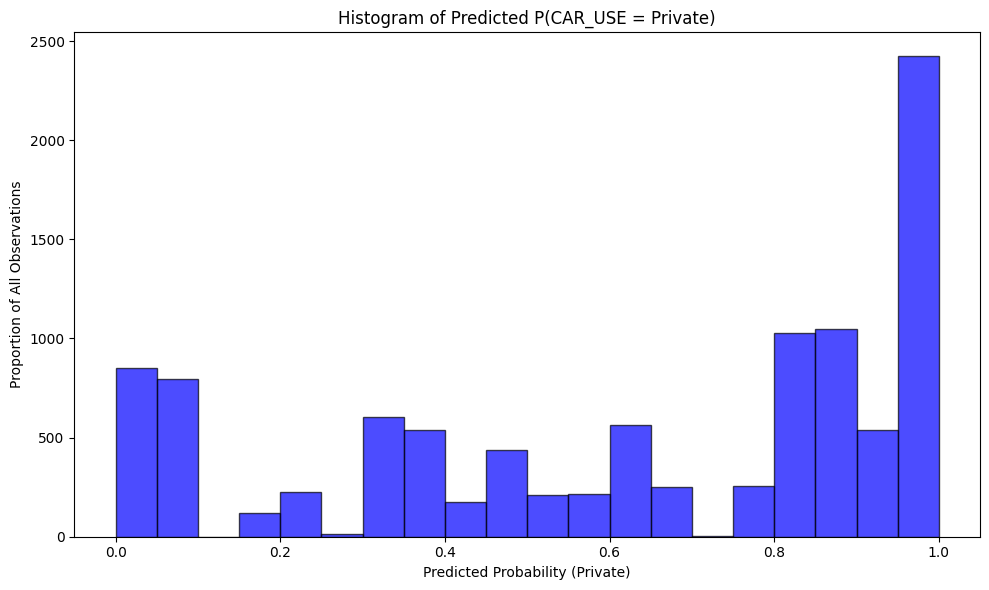

In [22]:
import matplotlib.pyplot as plt

private_idx = int(np.where(class_sorted == 'Private')[0][0])
probs_train = model.predict_proba(X_encoded)[:, private_idx]
bins = np.arange(0, 1.0001, 0.05)


plt.figure(figsize=(10, 6))
plt.hist(probs_train, bins=bins, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Predicted P(CAR_USE = Private)")
plt.xlabel("Predicted Probability (Private)")
plt.ylabel("Proportion of All Observations")
plt.tight_layout()
plt.show()

### 1.e (4 marks)

Using a classification threshold of 0.6 i.e., the class with a `probability >= 0.6` is the correct output, what is the misclassification rate (computed on **all the observations**) of the `CategoricalNB` model?

In [26]:
winning_idx = probabilities.argmax(axis=1)
winning_probs = probabilities[np.arange(len(probabilities)), winning_idx]

pred_threshold = np.where(winning_probs >= 0.6, winning_idx, -1)
missed = np.sum(pred_threshold != Y_encoded)
missed_rate = missed / len(Y_encoded)

print(f"\nMissed Rate with 0.6 Threshold: {missed_rate:.4f} ({missed} out of {len(Y_encoded)})")


Missed Rate with 0.6 Threshold: 0.1802 (1856 out of 10302)


### Problem 2: Logistic Regression Classification (25 marks)

`lab03_dataset_2.csv` contains 45,000 observations on loan details. You will use the observations in this dataset to train models that predict the status of a loan. The output label is the binary class *loan_status*, whose values are 0 and 1.

### 2.a (4 marks)

i. Use only the 8 numerical features as the input (ignore the categorical features).<br>
ii. Use sklearn's [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and `fit_transform` to transform the input features.<br>
iii. Then apply a train-test split of 80-20 to generate the training and testing sets.

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

CATEGORICAL = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']

df = pd.read_csv('lab03_dataset_2.csv')

num_features = df.select_dtypes(include=[np.number]).columns.tolist()
num_features.remove('loan_status')
X = df[num_features]
Y = df['loan_status']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=0, stratify=Y)                                         

### 2.b (4 marks)

Train a model using sklearn's [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and output the classification score.

In [52]:
from sklearn.linear_model import LogisticRegression 


model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print(f"\nLogistic Regression Test Accuracy: {score:.4f}")



Logistic Regression Test Accuracy: 0.8294


### 2.c (3 marks)

Compute the coefficients of the logistic regression model. What are the three most important features (features with the largest positive/negative coefficients are the most relevant)?

In [40]:
coefs = pd.Series(model.coef_[0], index=num_features).sort_values(ascending=False)
print("\nLogistic Regression Coefficients:")
print(coefs.to_string())

top3_positive = coefs.head(3)
top3_negative = coefs.tail(3)
print("\nTop 3 Positive Coefficients:\n", top3_positive.to_string())
print("\nTop 3 Negative Coefficients:\n", top3_negative.to_string())


Logistic Regression Coefficients:
loan_percent_income           1.330686
loan_int_rate                 1.001610
person_age                    0.101105
person_income                 0.019964
credit_score                 -0.006616
cb_person_cred_hist_length   -0.029527
person_emp_exp               -0.062718
loan_amnt                    -0.661744

Top 3 Positive Coefficients:
 loan_percent_income    1.330686
loan_int_rate          1.001610
person_age             0.101105

Top 3 Negative Coefficients:
 cb_person_cred_hist_length   -0.029527
person_emp_exp               -0.062718
loan_amnt                    -0.661744


Three most important features: loan_percent_income, loan_int_rate, and cb_person_cred_hist_length

### 2.d (3 marks)

Create a correlation heatmap using the three most important features and the output.

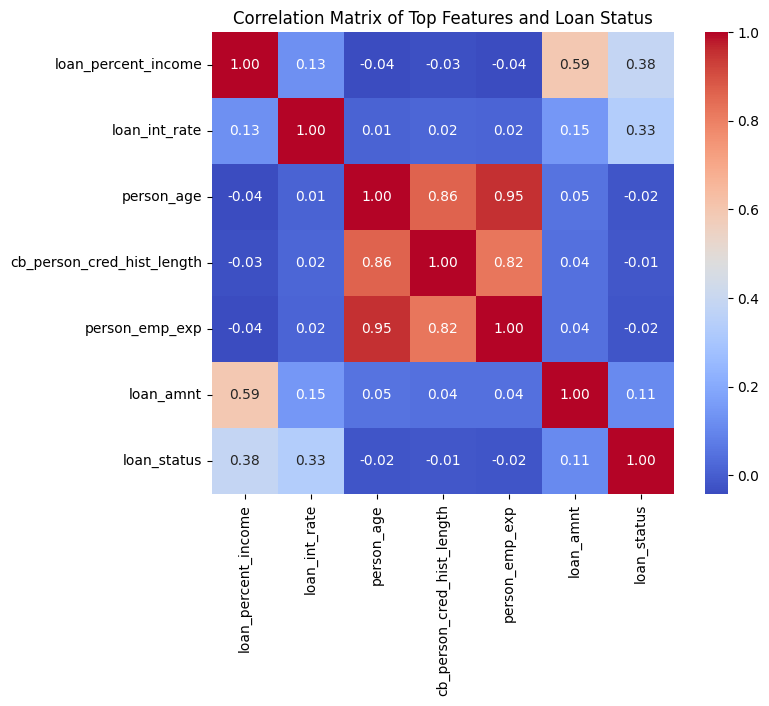

In [45]:
import seaborn as sns

top_feats = list(top3_positive.index) + list(top3_negative.index)
corr = df[top_feats + ['loan_status']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Top Features and Loan Status")                                 
plt.show()

### 2.e (4 marks)

Can we possibly improve the classification score? In the previous implementation, we completely ignored all the categorial features, so let us identify which of those categorical features can be used for improving performance. Encode the categorical features in such a way that it does not increase the number of columns in the original dataframe. Display the encoded dataframe.

In [46]:
cat_features = df.select_dtypes(exclude=[np.number]).columns.tolist()
encoded_df = df.copy()

for c in cat_features:
    encoded_df[c] = encoder.fit_transform(df[[c]].astype(str))

print(encoded_df.head())

   person_age  person_gender  person_education  person_income  person_emp_exp  \
0        22.0              0                 4        71948.0               0   
1        21.0              0                 3        12282.0               0   
2        25.0              0                 3        12438.0               3   
3        23.0              0                 1        79753.0               0   
4        24.0              1                 4        66135.0               1   

   person_home_ownership  loan_amnt  loan_intent  loan_int_rate  \
0                      3    35000.0            4          16.02   
1                      2     1000.0            1          11.14   
2                      0     5500.0            3          12.87   
3                      3    35000.0            3          15.23   
4                      3    35000.0            3          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                    

### 2.f (3 marks)

Re-create the correlation heatmap now using the encoded categorical features and the output. Choose three features with the highest correlation coefficient with the output class and add them to the original input features from 3.a. Remember, highest correlation coefficient takes into account the largest absolute values irrespective of positive or negative.


Top 3 Features Correlated with Loan Status:
 loan_percent_income      0.384880
loan_int_rate            0.332005
person_home_ownership    0.233842


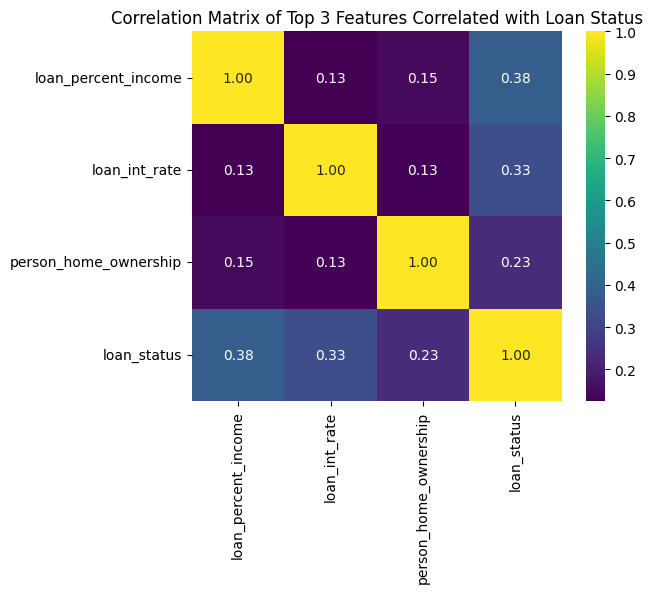

In [48]:
corr_all = encoded_df.corr()
target_corr = corr_all['loan_status'].drop('loan_status').sort_values(ascending=False)
top3 = target_corr.head(3)
print("\nTop 3 Features Correlated with Loan Status:\n", top3.to_string())

plt.Figure(figsize=(8, 6))
sns.heatmap(encoded_df[top3.index.tolist() + ['loan_status']].corr(), annot=True, fmt=".2f", cmap="viridis", square=True)
plt.title("Correlation Matrix of Top 3 Features Correlated with Loan Status")
plt.show()

### 2.g (4 marks)

Re-train the logistic regression model with the updated input features and compute the classification score.

In [50]:
enhanced = num_features + top3.index.tolist()
X_e = encoded_df[enhanced]
Y_e = encoded_df['loan_status']

X_e_scaled = scaler.fit_transform(X_e)
X_e_train, X_e_test, Y_e_train, Y_e_test = train_test_split(X_e_scaled, Y_e, test_size=0.2, random_state=0, stratify=Y_e)

model2 = LogisticRegression(max_iter=1000)
model2.fit(X_e_train, Y_e_train)
score2 = model2.score(X_e_test, Y_e_test)
print(f"\nEnhanced Logistic Regression Test Accuracy: {score2:.4f}")


Enhanced Logistic Regression Test Accuracy: 0.8401
